# Import Packages

In [147]:
# built-in packages
from ast import literal_eval
import itertools
import os
from pathlib import Path
import re

# third-party packages (install required)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.util import explained_variance
from scipy import stats
import seaborn as sns
from tqdm.notebook import tqdm

In [136]:
# Directory containing ICA outputs
P1K_PATH = '../../data/precise1k/'
K12_PATH = '../../data/k12_modulome/'
ANNOTATION_PATH = '../../data/annotation'
DATA_DIR_PROJ_REF = '../../data/k12_modulome/optica_k12_only/'
DATA_DIR_P1K_CTRL = '../../data/k12_modulome/optica_k12_only_p1k_ctrl/'
FIG_PATH = 'summarize_imodulons_figs'

# Load P1K and Public K-12

In [70]:
p1k = load_json_model(Path(P1K_PATH, 'precise1k.json.gz').as_posix())
k12 = load_json_model(Path(K12_PATH, 'k12_modulome.json.gz').as_posix())

# Choose Dimensionality

## Project Reference

### Load Data

In [5]:
def load_M(dim):
    return pd.read_csv(os.path.join(DATA_DIR_PROJ_REF,str(dim),'S.csv'),index_col=0)

def load_A(dim):
    return pd.read_csv(os.path.join(DATA_DIR_PROJ_REF,str(dim),'A.csv'),index_col=0)

In [6]:
dims = sorted([int(x) for x in os.listdir(DATA_DIR_PROJ_REF) if 'DS' not in x and int(x) <= 380])
M_data = [load_M(dim) for dim in dims]
A_data = [load_A(dim) for dim in dims]

In [8]:
n_components = [m.shape[1] for m in M_data]

### Compare Dimensionalities

In [9]:
final_m = M_data[-1]
thresh = 0.7

In [10]:
n_final_mods = []
for m in tqdm(M_data):
    corrs = pd.DataFrame(index=final_m.columns,columns=m.columns)
    for col1 in final_m.columns:
        for col2 in m.columns:
            corrs.loc[col1,col2] = abs(stats.pearsonr(final_m[col1],m[col2])[0])
    n_final_mods.append(len(np.where(corrs > thresh)[0]))

  0%|          | 0/29 [00:00<?, ?it/s]

### Find "single-gene" iModulons
At a high enough dimensionality, some iModulons track the expression trajectory of a single iModulon

In [11]:
n_single_genes = []
for m in tqdm(M_data):
    counter = 0
    for col in m.columns:
        sorted_genes = abs(m[col]).sort_values(ascending=False)
        if sorted_genes.iloc[0] > 2 * sorted_genes.iloc[1]:
            counter += 1
    n_single_genes.append(counter)

  0%|          | 0/29 [00:00<?, ?it/s]

### Plot Components

In [12]:
non_single_components = np.array(n_components) - np.array(n_single_genes)

In [13]:
DF_stats = pd.DataFrame([n_components,n_final_mods,non_single_components,n_single_genes],
                        index=['Robust Components','Final Components','Multi-gene Components',
                        'Single Gene Components'],
                        columns=dims).T
DF_stats.sort_index(inplace=True)

In [14]:
dimensionality = DF_stats[DF_stats['Final Components'] >= DF_stats['Multi-gene Components']].iloc[0].name
print('Optimal Dimensionality:',dimensionality)

Optimal Dimensionality: 220


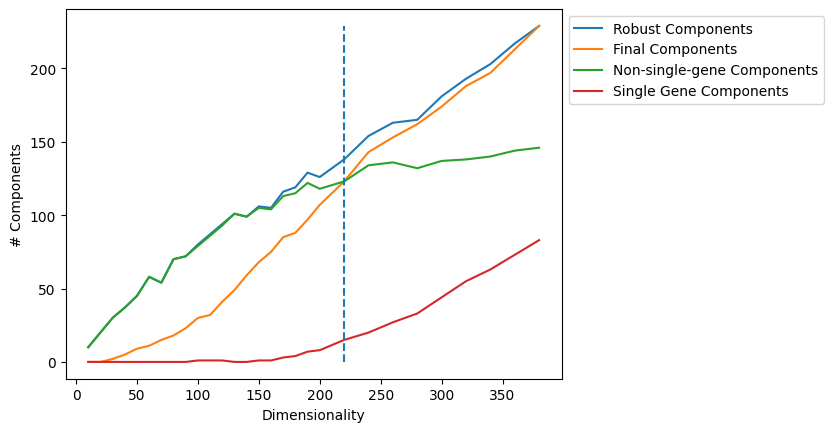

In [15]:
plt.plot(dims,n_components,label='Robust Components')
plt.plot(dims,n_final_mods,label='Final Components')
plt.plot(dims,non_single_components,label='Non-single-gene Components')
plt.plot(dims,n_single_genes,label='Single Gene Components')

plt.vlines(dimensionality,0,max(n_components),linestyle='dashed')

plt.xlabel('Dimensionality')
plt.ylabel('# Components')
plt.legend(bbox_to_anchor=(1,1))

## P1K Ctrl Reference

### Load Data

In [16]:
def load_M(dim):
    return pd.read_csv(os.path.join(DATA_DIR_P1K_CTRL,str(dim),'S.csv'),index_col=0)

def load_A(dim):
    return pd.read_csv(os.path.join(DATA_DIR_P1K_CTRL,str(dim),'A.csv'),index_col=0)

In [17]:
dims = sorted([int(x) for x in os.listdir(DATA_DIR_P1K_CTRL) if 'DS' not in x and int(x) <= 380])
M_data = [load_M(dim) for dim in dims]
A_data = [load_A(dim) for dim in dims]

In [18]:
n_components = [m.shape[1] for m in M_data]

### Compare Dimensionalities

In [19]:
final_m = M_data[-1]
thresh = 0.7

In [20]:
n_final_mods = []
for m in tqdm(M_data):
    corrs = pd.DataFrame(index=final_m.columns,columns=m.columns)
    for col1 in final_m.columns:
        for col2 in m.columns:
            corrs.loc[col1,col2] = abs(stats.pearsonr(final_m[col1],m[col2])[0])
    n_final_mods.append(len(np.where(corrs > thresh)[0]))

  0%|          | 0/29 [00:00<?, ?it/s]

### Find "single-gene" iModulons
At a high enough dimensionality, some iModulons track the expression trajectory of a single iModulon

In [21]:
n_single_genes = []
for m in tqdm(M_data):
    counter = 0
    for col in m.columns:
        sorted_genes = abs(m[col]).sort_values(ascending=False)
        if sorted_genes.iloc[0] > 2 * sorted_genes.iloc[1]:
            counter += 1
    n_single_genes.append(counter)

  0%|          | 0/29 [00:00<?, ?it/s]

### Plot Components

In [22]:
non_single_components = np.array(n_components) - np.array(n_single_genes)

In [23]:
DF_stats = pd.DataFrame([n_components,n_final_mods,non_single_components,n_single_genes],
                        index=['Robust Components','Final Components','Multi-gene Components',
                        'Single Gene Components'],
                        columns=dims).T
DF_stats.sort_index(inplace=True)

In [24]:
dimensionality = DF_stats[DF_stats['Final Components'] >= DF_stats['Multi-gene Components']].iloc[0].name
print('Optimal Dimensionality:',dimensionality)

Optimal Dimensionality: 280


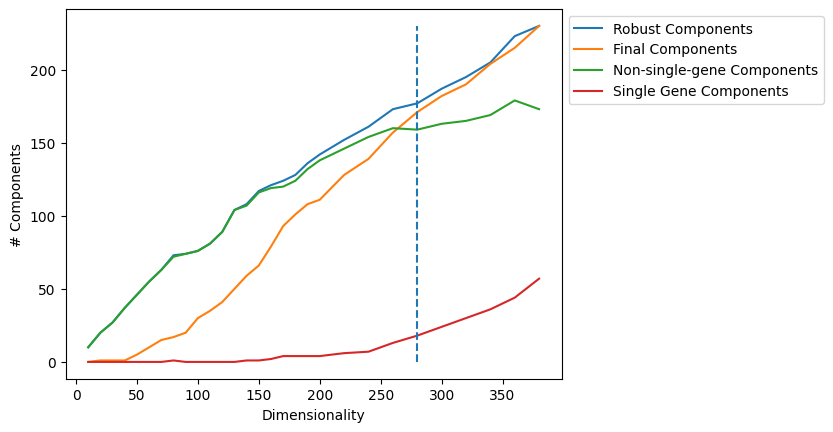

In [25]:
plt.plot(dims,n_components,label='Robust Components')
plt.plot(dims,n_final_mods,label='Final Components')
plt.plot(dims,non_single_components,label='Non-single-gene Components')
plt.plot(dims,n_single_genes,label='Single Gene Components')

plt.vlines(dimensionality,0,max(n_components),linestyle='dashed')

plt.xlabel('Dimensionality')
plt.ylabel('# Components')
plt.legend(bbox_to_anchor=(1,1))

# Create IcaData

In [27]:
k12_only_metadata = k12.sample_table.iloc[1035:]

In [28]:
ica_data_proj_ref = IcaData(
    M=os.path.join(DATA_DIR_PROJ_REF, '220','S.csv'),
    A=os.path.join(DATA_DIR_PROJ_REF, '220','A.csv'),
    gene_table=os.path.join(ANNOTATION_PATH,'gene_info.csv'),
    sample_table=k12_only_metadata,
    trn=os.path.join(ANNOTATION_PATH,'TRN.csv'),
    optimize_cutoff=True
)
save_to_json(ica_data_proj_ref, Path(K12_PATH, 'k12_only_proj_ref').as_posix(), compress=True)

ica_data_p1k_ctrl = IcaData(
    M=os.path.join(DATA_DIR_P1K_CTRL, '280','S.csv'),
    A=os.path.join(DATA_DIR_P1K_CTRL, '280','A.csv'),
    gene_table=os.path.join(ANNOTATION_PATH,'gene_info.csv'),
    sample_table=k12_only_metadata,
    trn=os.path.join(ANNOTATION_PATH,'TRN.csv'),
    optimize_cutoff=True
)
save_to_json(ica_data_p1k_ctrl, Path(K12_PATH, 'k12_only_p1k_ctrl').as_posix(), compress=True)

# Compare iMs to P1K and K-12

In [29]:
for ica_data_name in ['k12_only_proj_ref', 'k12_only_p1k_ctrl']:
    
    ica_data = load_json_model(Path(K12_PATH, f'{ica_data_name}.json.gz').as_posix())

    match_rows = []
    for match in compare_ica(p1k.M, ica_data.M, method='pearson')[0]:
        match_rows.append({
            'dataset': 'P1K',
            'iM': match[0],
            'k12_only_im': match[1],
            'method': 'pearson',
            'corr': match[2]
        })
    for match in compare_ica(p1k.M, ica_data.M, method='spearman')[0]:
        match_rows.append({
            'dataset': 'P1K',
            'iM': match[0],
            'k12_only_im': match[1],
            'method': 'spearman',
            'corr': match[2]
        })
    for match in compare_ica(k12.M, ica_data.M, method='pearson')[0]:
        match_rows.append({
            'dataset': 'K12',
            'iM': match[0],
            'k12_only_im': match[1],
            'method': 'pearson',
            'corr': match[2]
        })
    for match in compare_ica(k12.M, ica_data.M, method='spearman')[0]:
        match_rows.append({
            'dataset': 'K12',
            'iM': match[0],
            'k12_only_im': match[1],
            'method': 'spearman',
            'corr': match[2]
        })

    match_df = pd.DataFrame(match_rows)
    
    for im, im_row in ica_data.imodulon_table.iterrows():
        im_match = match_df[match_df['k12_only_im'] == im]
        if not im_match.empty:
            for dataset, dataset_match_df in im_match.groupby('dataset'):
                max_corr = np.argmax(dataset_match_df['corr'])
                max_corr_im = dataset_match_df.iloc[max_corr]['iM']
                max_corr_im_df = dataset_match_df[dataset_match_df['iM'] == max_corr_im]
                for _, max_corr_row in max_corr_im_df.iterrows():
                    ica_data.imodulon_table.loc[im, max_corr_row['dataset']] = max_corr_row['iM']
                    ica_data.imodulon_table.loc[
                        im, f"{max_corr_row['dataset']}_{max_corr_row['method']}"
                    ] = max_corr_row['corr']
                    
    always_copy_cols = [
        'enrichment_category', 'system_category', 'functional_category', 'function', 'confidence',
        'note', 'single_gene_dominant_technical', 'tcs', 'regulon_discovery', 'ko'
    ]

    for i, (im, im_row) in enumerate(ica_data.imodulon_table.iterrows()):
        if pd.notna(im_row['P1K']) and im_row['P1K'] != '':
            p1k_im_row = p1k.imodulon_table.loc[im_row['P1K']]
            print(f"({i+1}/{ica_data.imodulon_table.shape[0]}) {im} -> {im_row['P1K']}")
            ica_data.imodulon_table.loc[im, always_copy_cols] = p1k.imodulon_table.loc[im_row['P1K'], always_copy_cols]
            if pd.notna(p1k_im_row['trn_enrich_max_regs']):
                enrich_res = ica_data.compute_trn_enrichment(im, max_regs=int(p1k_im_row['trn_enrich_max_regs']),
                                                evidence=literal_eval(p1k_im_row['trn_enrich_evidence']), force=True,
                                                method=p1k_im_row['trn_enrich_method'])
                enrich_res_with_reg = enrich_res[enrich_res['regulator'] == p1k_im_row['regulator']]
                if enrich_res_with_reg.empty:
                    continue
                ica_data.imodulon_table.loc[
                    im,
                    ['regulator', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ] = enrich_res_with_reg.iloc[0][[
                    'regulator', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs'
                ]]
                ica_data.imodulon_table.loc[
                    im,
                    [
                        'trn_enrich_max_regs',
                        'trn_enrich_evidence',
                        'trn_enrich_method'
                    ]
                ] = [
                    p1k_im_row['trn_enrich_max_regs'],
                    p1k_im_row['trn_enrich_evidence'],
                    p1k_im_row['trn_enrich_method']
                ]
            elif pd.notna(p1k_im_row['compute_regulon_evidence']):
                enrich_res = ica_data.compute_regulon_enrichment(im, p1k_im_row['regulator'],
                            evidence=literal_eval(p1k_im_row['compute_regulon_evidence']))
                ica_data.imodulon_table.loc[
                    im,
                    ['pvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ] = enrich_res[
                    ['pvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ]
                ica_data.imodulon_table.loc[im, 'regulator'] = p1k_im_row['regulator']
                ica_data.imodulon_table.loc[im, 'compute_regulon_evidence'] = p1k_im_row['compute_regulon_evidence']

        elif pd.notna(im_row['K12']) and im_row['K12'] != '':
            k12_im_row = k12.imodulon_table.loc[im_row['K12']]
            print(f"({i+1}/{ica_data.imodulon_table.shape[0]}) {im} -> {im_row['K12']}")
            ica_data.imodulon_table.loc[im, always_copy_cols] = k12.imodulon_table.loc[im_row['K12'], always_copy_cols]
            if pd.notna(k12_im_row['trn_enrich_max_regs']):
                enrich_res = ica_data.compute_trn_enrichment(im, max_regs=int(k12_im_row['trn_enrich_max_regs']),
                                                evidence=literal_eval(k12_im_row['trn_enrich_evidence']), force=True,
                                                method=k12_im_row['trn_enrich_method'])
                enrich_res_with_reg = enrich_res[enrich_res['regulator'] == k12_im_row['regulator']]
                if enrich_res_with_reg.empty:
                    continue
                ica_data.imodulon_table.loc[
                    im,
                    ['regulator', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ] = enrich_res_with_reg.iloc[0][[
                    'regulator', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs'
                ]]
                ica_data.imodulon_table.loc[
                    im,
                    [
                        'trn_enrich_max_regs',
                        'trn_enrich_evidence',
                        'trn_enrich_method'
                    ]
                ] = [
                    k12_im_row['trn_enrich_max_regs'],
                    k12_im_row['trn_enrich_evidence'],
                    k12_im_row['trn_enrich_method']
                ]
            elif pd.notna(k12_im_row['compute_regulon_evidence']):
                enrich_res = ica_data.compute_regulon_enrichment(im, k12_im_row['regulator'],
                            evidence=literal_eval(k12_im_row['compute_regulon_evidence']))
                ica_data.imodulon_table.loc[
                    im,
                    ['pvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ] = enrich_res[
                    ['pvalue', 'precision', 'recall', 'f1score', 'TP', 'regulon_size', 'n_regs']
                ]
                ica_data.imodulon_table.loc[im, 'regulator'] = k12_im_row['regulator']
                ica_data.imodulon_table.loc[im, 'compute_regulon_evidence'] = k12_im_row['compute_regulon_evidence']
                
    save_to_json(ica_data, Path(K12_PATH, ica_data_name).as_posix(), compress=True)

(1/138) 0 -> CsrA
(2/138) 1 -> Leu/Val/Ile
(3/138) 2 -> Glycerol
(4/138) 3 -> Tryptophanase
(5/138) 4 -> Empty
(6/138) 5 -> NrdR
(7/138) 6 -> minicoli KOs-3
(8/138) 7 -> Fimbriae
(9/138) 8 -> YgeV
(10/138) 9 -> Zinc-1
(11/138) 10 -> IS Elements-2
(13/138) 12 -> FliA
(14/138) 13 -> PaaX
(15/138) 14 -> Suf System
(16/138) 15 -> Magnesium
(17/138) 16 -> Microaerobic
(19/138) 18 -> OxyR
(20/138) 19 -> SoxS
(21/138) 20 -> RpoH
(22/138) 21 -> Glutamine
(23/138) 22 -> Capsule
(24/138) 23 -> SoxR/ECA
(26/138) 25 -> Sulfate
(27/138) 26 -> FDH-N/NRA
(28/138) 27 -> YmfT
(29/138) 28 -> LPS
(30/138) 29 -> Translation
(31/138) 30 -> Biofilm
(33/138) 32 -> Arginine
(34/138) 33 -> Fnr-1
(35/138) 34 -> Crp-1
(36/138) 35 -> Copper
(37/138) 36 -> Exuronate
(38/138) 37 -> Maltose
(39/138) 38 -> ppGpp
(40/138) 39 -> Quorum Sensing
(41/138) 40 -> NO Stress
(42/138) 41 -> NDH-1
(43/138) 42 -> ytiC
(44/138) 43 -> Lysine/T2SS
(45/138) 44 -> Fnr-3
(46/138) 45 -> Pyruvate-2
(47/138) 46 -> Crp-2
(48/138) 47 -> Fl

# Compare iM Overlap and Reg Coverage

In [108]:
k12_only = load_json_model(os.path.join(K12_PATH, 'k12_only_p1k_ctrl.json.gz'))

In [109]:
k12_only_im_table = k12_only.imodulon_table.assign(
    has_match=k12_only.imodulon_table['K12'].notna()
)

k12_im_table = k12.imodulon_table.assign(
    has_match=pd.Series(k12.imodulon_table.index).apply(lambda im_name: im_name in list(k12_only_im_table['K12'].dropna())).values
)

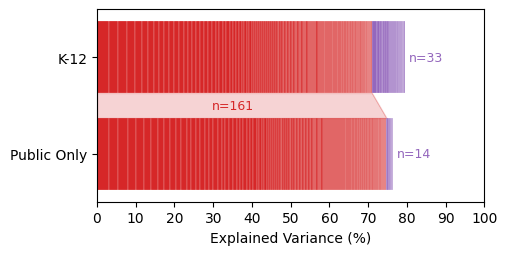

In [139]:
_, ax = plt.subplots(figsize=(5, 2.5))

col_dict = {
    True: 'tab:red',
    False: 'tab:purple'
}

prev_left = 0
cat_bounds_k12 = {}
for match_bool, corr_cat_df in list(k12_im_table.groupby('has_match'))[::-1]:
    cat_start = prev_left
    for im, im_row in corr_cat_df.sort_values(by='exp_var', ascending=False).iterrows():
        ax.barh(2, im_row['exp_var']*100, left=prev_left, linewidth=0.15, height=0.75, color=col_dict[match_bool], edgecolor='white')
        prev_left += im_row['exp_var']*100
    cat_bounds_k12[match_bool] = (cat_start, prev_left)
        
prev_left = 0
cat_bounds_k12_only = {}
for match_bool, corr_cat_df in list(k12_only_im_table.groupby('has_match'))[::-1]:
    cat_start = prev_left
    for im, im_row in corr_cat_df.sort_values(by='exp_var', ascending=False).iterrows():
        ax.barh(1, im_row['exp_var']*100, left=prev_left, linewidth=0.15, height=0.75, color=col_dict[match_bool], edgecolor='white')
        prev_left += im_row['exp_var']*100
    cat_bounds_k12_only[match_bool] = (cat_start, prev_left)
    
ax.plot((cat_bounds_k12[True][1], cat_bounds_k12_only[True][1]), (1.63, 1.375), color='tab:red', linewidth=0.2, alpha=0.4)
ax.fill_between([0, cat_bounds_k12[True][1], cat_bounds_k12_only[True][1]], y1=[1.37, 1.37, 1.37], y2=[1.63, 1.63, 1.375], color='tab:red', alpha=0.2)

ax.text(35, 1.5, 'n=161', ha='center', va='center', fontsize=9, color='tab:red')
ax.text(cat_bounds_k12[False][1] + 1, 2, f'n=33', ha='left', va='center', fontsize=9, color='tab:purple')
ax.text(cat_bounds_k12_only[False][1] + 1, 1, f'n=14', ha='left', va='center', fontsize=9, color='tab:purple')
        
ax.set_xlim(0, 100)
ax.set_ylim(0.5, 2.5)
ax.set_yticks([1, 2])
ax.set_xticks(range(0, 110, 10))
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels(['Public Only', 'K-12'])
ax.set_xlabel('Explained Variance (%)', fontsize=10)

plt.savefig(os.path.join(FIG_PATH, 'k12_only_im_comp.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'k12_only_im_comp.png'), dpi=400, bbox_inches='tight')

K-12 + P1K Coverage (copied from other notebook)

100/190 (53%) regulators with some strong evidence in iModulons

130/370 (35%) regulators in iModulons

1214/3417 (36%) strong evidence interactions in iModulons (3000 [88%] strong interactions have regulator in iModulon)

2297/9092 (25%) interactions in iModulons (7256 [80%] interactions have regulator in iModulon)


In [144]:
trn = pd.read_csv(os.path.join(ANNOTATION_PATH, 'TRN.csv'))

all_p1k_regs = []
all_p1k_reg_interacts = []
for _, imod_row in k12_only_im_table.iterrows():
    im_regs = imod_row['regulator']
    if pd.notna(im_regs):
        regs = re.split(f'/|\+', im_regs)
        all_p1k_regs.extend(regs)
        im_genes = k12_only.view_imodulon(imod_row.name).index
        all_p1k_reg_interacts.extend(list(itertools.product(regs, im_genes)))

all_p1k_regs = list(set(all_p1k_regs))
all_p1k_reg_interacts = list(set(all_p1k_reg_interacts))

# now annotate the trn with the info from imodulon table
trn = trn.assign(
    reg_in_ims=trn['regulator'].apply(lambda reg: reg in all_p1k_regs),
    interact_in_ims=trn.apply(lambda row: (row['regulator'], row['gene_id']) in all_p1k_reg_interacts, axis=1)
)

trn = trn[trn['regulator'] != 'RpoD']

by_reg = trn.groupby('regulator').sum()
by_reg = by_reg.assign(
    evidence=by_reg.evidence.apply(lambda ev: 'Weak' if ev == 0 else 'Strong'),
    reg_in_ims=by_reg.reg_in_ims.apply(lambda in_im: in_im != 0),
    n_interact=trn.groupby('regulator').count().get('gene_name')
)

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_24103/3862291862.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_reg = trn.groupby('regulator').sum()


In [145]:
n_strong_in_im = by_reg[(by_reg['evidence'] == 'Strong') & (by_reg['reg_in_ims'])].shape[0]
n_strong_total = by_reg[(by_reg['evidence'] == 'Strong')].shape[0]

print(f'{n_strong_in_im}/{n_strong_total} ({n_strong_in_im/n_strong_total*100:.0f}%) regulators with some strong evidence in iModulons')

all_in_im = by_reg[by_reg['reg_in_ims']].shape[0]
all_total = by_reg.shape[0]
print(f'{all_in_im}/{all_total} ({all_in_im/all_total*100:.0f}%) regulators in iModulons')

n_strong_interact_in_im = trn[(trn['evidence'] > 0) & (trn['interact_in_ims'])].shape[0]
n_strong_interact_w_reg_in_im = trn[(trn['evidence'] > 0) & (trn['reg_in_ims'])].shape[0]
n_strong_interact = trn[(trn['evidence'] > 0)].shape[0]

print(f'{n_strong_interact_in_im}/{n_strong_interact} ({n_strong_interact_in_im/n_strong_interact*100:.0f}%) strong evidence interactions in iModulons',
      f'({n_strong_interact_w_reg_in_im} [{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%] strong interactions have regulator in iModulon)')

all_interact_in_im = trn[trn['interact_in_ims']].shape[0]
n_interact_w_reg_in_im = trn[trn['reg_in_ims']].shape[0]
all_interact_total = trn.shape[0]

print(f'{all_interact_in_im}/{all_interact_total} ({all_interact_in_im/all_interact_total*100:.0f}%) interactions in iModulons',
      f'({n_interact_w_reg_in_im} [{n_interact_w_reg_in_im/all_interact_total*100:.0f}%] interactions have regulator in iModulon)')

78/190 (41%) regulators with some strong evidence in iModulons
104/370 (28%) regulators in iModulons
1085/3417 (32%) strong evidence interactions in iModulons (2799 [82%] strong interactions have regulator in iModulon)
2007/9092 (22%) interactions in iModulons (6927 [76%] interactions have regulator in iModulon)


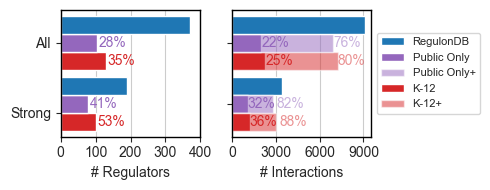

In [161]:
sns.set_style('ticks')
fig, (ax_tfs, ax_ris) = plt.subplots(1, 2, figsize=(5, 2))

ax_tfs.barh(0.125, 100, height=0.25, color='tab:red')
ax_tfs.barh(0.375, n_strong_in_im, height=0.25, color='tab:purple')
ax_tfs.barh(0.625, n_strong_total, height=0.25, color='tab:blue')
ax_tfs.text(100 + 5, 0.125, f'{100/190*100:.0f}%', va='center', ha='left', color='tab:red')
ax_tfs.text(n_strong_in_im + 5, 0.375, f'{n_strong_in_im/n_strong_total*100:.0f}%', va='center', ha='left', color='tab:purple')
ax_tfs.barh(0.975, 130, height=0.25, color='tab:red')
ax_tfs.barh(1.225, all_in_im, height=0.25, color='tab:purple')
ax_tfs.barh(1.475, all_total, height=0.25, color='tab:blue')
ax_tfs.text(130 + 5, 0.975, f'{130/370*100:.0f}%', va='center', ha='left', color='tab:red')
ax_tfs.text(all_in_im + 5, 1.225, f'{all_in_im/all_total*100:.0f}%', va='center', ha='left', color='tab:purple')

for s in ax_tfs.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
ax_tfs.set_xlabel('# Regulators')
ax_tfs.set_yticks([0.25, 1.225])
ax_tfs.set_yticklabels(['Strong', 'All'])
ax_tfs.set_xticks(np.arange(0, 500, 100))
ax_tfs.xaxis.grid(True)

ax_ris.barh(0.625, n_strong_interact, height=0.25, color='tab:blue', label='RegulonDB')
ax_ris.barh(0.375, n_strong_interact_in_im, height=0.25, color='tab:purple', label='Public Only')
ax_ris.text(n_strong_interact_in_im + 1, 0.375, f'{n_strong_interact_in_im/n_strong_interact*100:.0f}%',
            ha='left', va='center', color='tab:purple')
ax_ris.barh(0.375, n_strong_interact_w_reg_in_im, height=0.25, color='tab:purple', alpha=0.5, label='Public Only+')
ax_ris.text(n_strong_interact_w_reg_in_im + 250, 0.375, f'{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%',
            ha='left', va='center', color='tab:purple', alpha=0.5)
ax_ris.barh(0.125, 1214, height=0.25, color='tab:red', label='K-12')
ax_ris.text(1214 + 1, 0.125, f'{1214/n_strong_interact*100:.0f}%',
            ha='left', va='center', color='tab:red')
ax_ris.barh(0.125, 3000, height=0.25, color='tab:red', label='K-12+', alpha=0.5)
ax_ris.text(3000 + 250, 0.125, f'{3000/n_strong_interact*100:.0f}%',
            ha='left', va='center', color='tab:red', alpha=0.5)
ax_ris.barh(0.975, 2297, height=0.25, color='tab:red')
ax_ris.text(2297 + 1, 0.975, f'{2297/all_interact_total*100:.0f}%',
            ha='left', va='center', color='tab:red')
ax_ris.barh(0.975, 7256, height=0.25, color='tab:red', alpha=0.5)
ax_ris.text(7256 + 1, 0.975, f'{7256/all_interact_total*100:.0f}%',
            ha='left', va='center', color='tab:red', alpha=0.5)
ax_ris.barh(1.225, all_interact_in_im, height=0.25, color='tab:purple')
ax_ris.text(all_interact_in_im + 1, 1.225, f'{all_interact_in_im/all_interact_total*100:.0f}%',
            ha='left', va='center', color='tab:purple')
ax_ris.barh(1.225, n_interact_w_reg_in_im, height=0.25, color='tab:purple', alpha=0.5)
ax_ris.text(n_interact_w_reg_in_im + 1, 1.225, f'{n_interact_w_reg_in_im/all_interact_total*100:.0f}%',
            ha='left', va='center', color='tab:purple', alpha=0.5)
ax_ris.barh(1.475, all_interact_total, height=0.25, color='tab:blue')

for s in ax_ris.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
    
ax_ris.set_xlabel('# Interactions')
ax_ris.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=8)
ax_ris.set_yticks([0.375, 1.225])
ax_ris.set_yticklabels([])
ax_ris.set_xticks(np.arange(0, 12000, 3000))
ax_ris.xaxis.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'reg_coverage_k12_only.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'reg_coverage_k12_only.png'), dpi=400, bbox_inches='tight')